In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime
from dateutil.relativedelta import relativedelta

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import glob, os

from eofs.xarray import Eof
from eofs.standard import Eof as sEof # If needed

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree()

### AN EXAMPLE FILE (don't run the code it takes a while and ur thing works for the most part):

url = 'http://kage.ldeo.columbia.edu:81/SOURCES/.LOCAL/.sst.mon.mean.nc/.sst/dods'
ds = xr.open_dataset(url)
ds_anom = ds.groupby('time.month') - ds.groupby('time.month').mean()
solver = Eof(ds_anom.sst)

eofs = solver.eofsAsCorrelation(neofs=3)
#pcs = solver.pcs(npcs=3)
eofs.plot(x='x',y='y',col='mode',col_wrap=3,add_colorbar=0)
#pcs.plot(x='tdim',col='mode',col_wrap=3); #PCS DOES NOT WORK.

## currently: 20x180 lat/long grid w/ 2x2 degree cells, climatological anomalies

In [2]:
filename = '/d6/bxw2101/combined_netcdf_files/sic_anom_monthly_2x2.nc'
sic_anom_ds = xr.open_dataset(filename)
sic_anom = sic_anom_ds.sic_anom
sic_anom = sic_anom.fillna(0) # fillna(0) replaces all the nan values with zeroes. need to do this or else the solver doesn't work.
sic_anom_og = sic_anom.isel(tdim=slice(0, 264))

coslat = np.cos(np.deg2rad(sic_anom_ds.coords['y'].values)).clip(0., 1.)
wgts = coslat[..., np.newaxis]

[0.38056063 0.26071223 0.2248379  0.18143764 0.14175099]


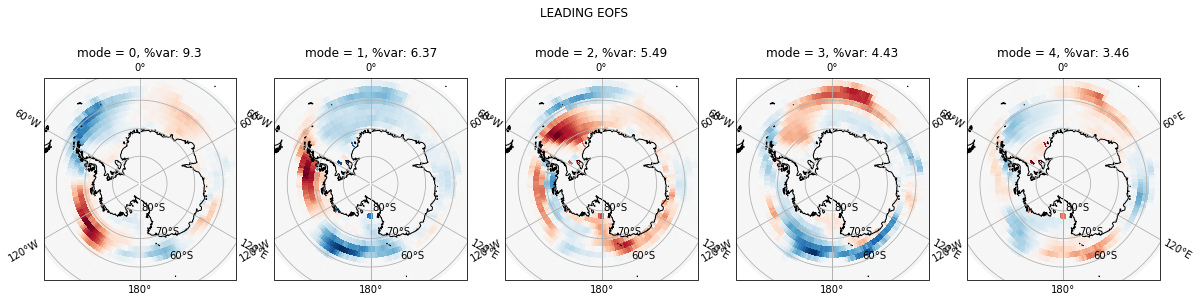

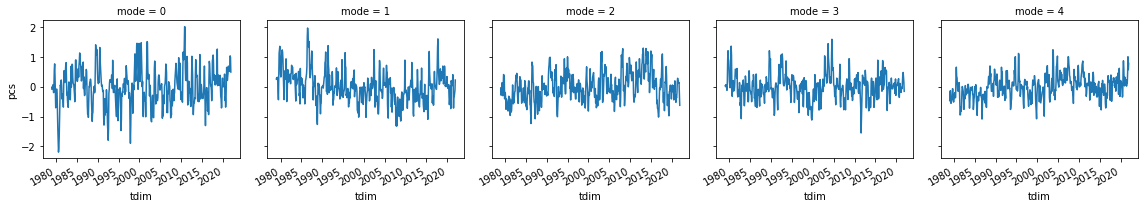

In [3]:
# First dimension: time. Second dimension: y (lat). Third dimension: x (lon)
# Using the xarray solver:
xsolver = Eof(sic_anom, weights=wgts)
modes = 5

eofs = xsolver.eofsAsCovariance(neofs=modes) # mode: 412, y: 20, x: 180
pcs = xsolver.pcs(npcs=modes) # tdim: 516, mode: 412
eigs = xsolver.eigenvalues(neigs=modes) 
sum_eigs = xsolver.eigenvalues().sum().data

# Plot EOFs
fig = plt.figure(figsize=(20,5))
for mode in range(modes):
    ax = plt.subplot(1, 5, mode + 1, projection=sp)
    im = eofs[mode].plot(transform=pc, add_colorbar=False)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('mode = ' + str(mode) + ', %var: ' + str(round(eigs[mode].data/sum_eigs * 100, 2)))
    
plt.suptitle('LEADING EOFS')
# eofs.plot(x='x',y='y',col='mode',col_wrap=modes,add_colorbar=0)

# Plot corresponding PCs
pcs.plot(x='tdim',col='mode',col_wrap=modes);
print(eigs.data)

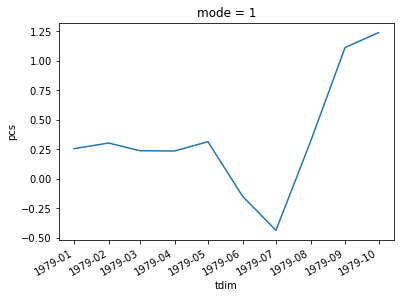

In [4]:
#pcs.sel(mode=1).plot()
pcs.sel(mode=1)[0:10].plot()

In [7]:
eigs = xsolver.eigenvalues(neigs=modes)
print(eigs.sum().data/sum_eigs)

0.2904833961536724


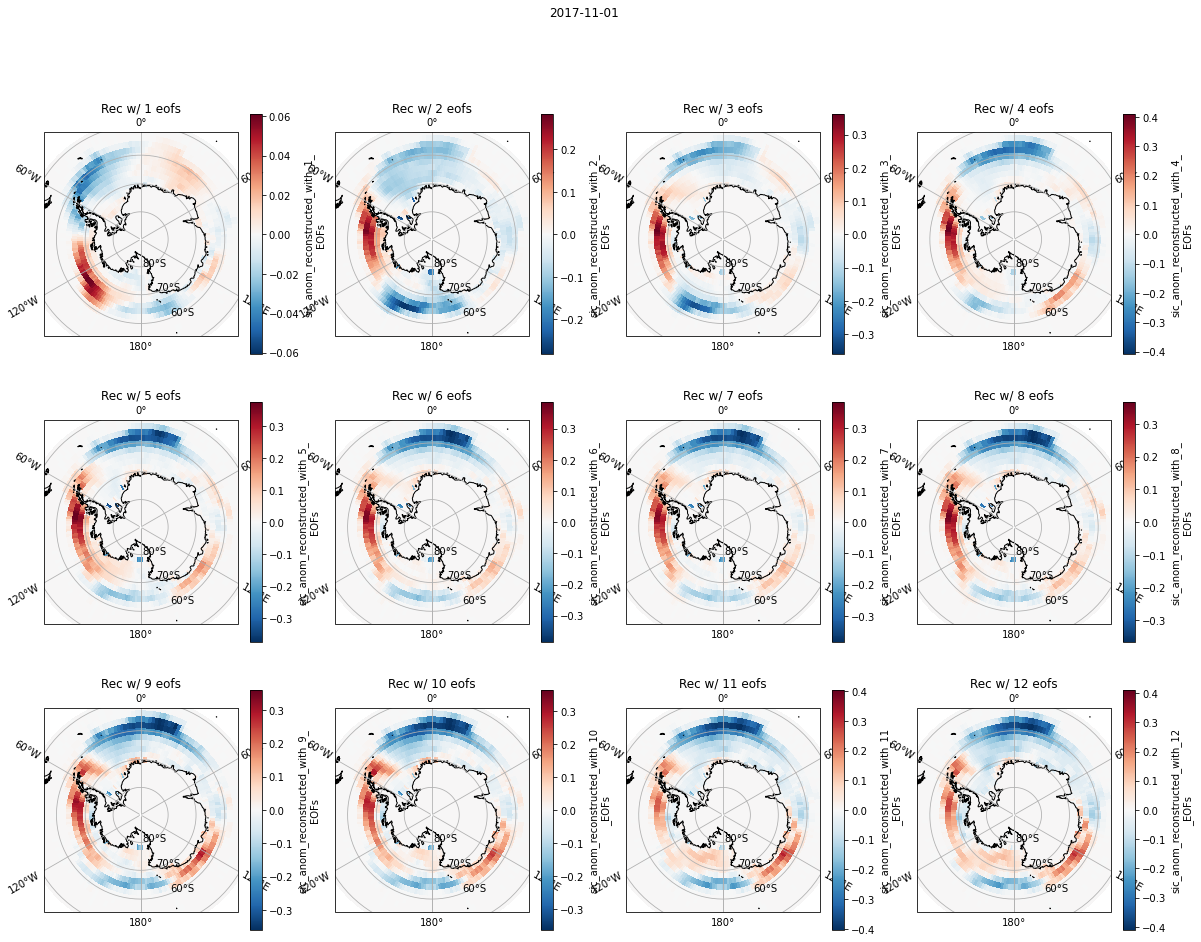

In [8]:
# Reconstruction of 2017-11-01.
fig = plt.figure(figsize=(20,15))

neofs = 12
for neof in range(1, neofs + 1):
    reconstruction = xsolver.reconstructedField(neof)
    #reconstruction

    ax = plt.subplot(3, 4, neof, projection=sp)
    im = reconstruction.sel(tdim='2017-11-01').plot(transform=pc)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('Rec w/ ' + str(neof) + ' eofs')
    plt.suptitle('2017-11-01')

Text(0.5, 0.98, 'RECONSTRUCTION ')

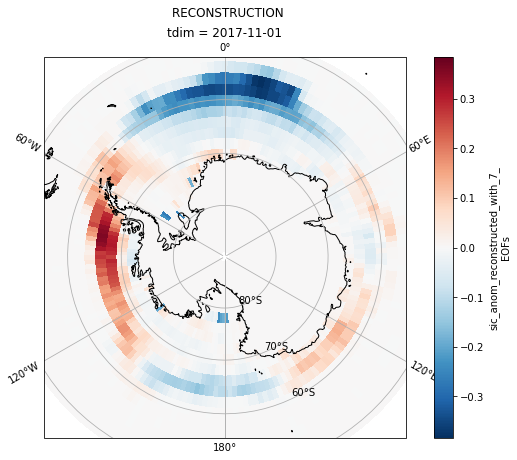

In [5]:
# One reconstruction of 2017-11-01

fig = plt.figure(figsize=(10,7))

reconstruction = xsolver.reconstructedField(7) #reconstructed with 7 leading modes

ax = plt.axes(projection=sp)
reconstruction.sel(tdim='2017-11-01').plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
#arb_time.plot(transform=pc)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.suptitle('RECONSTRUCTION ')

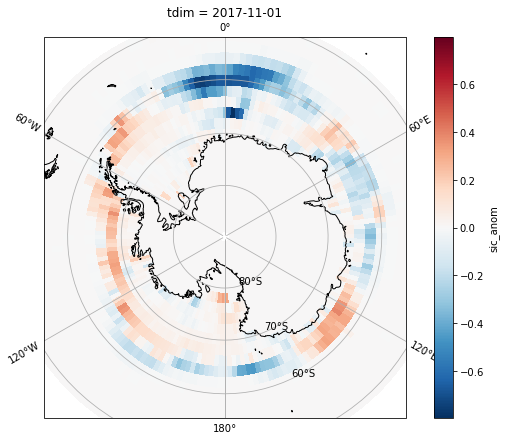

In [10]:
# 2017-11-01 anomaly from the dataset

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
sic_anom.sel(tdim='2017-11-01').plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
#arb_time.plot(transform=pc)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

## Seeing correlation btwn the reconstructed with the actual data (not the actual way to pick the modes lol. just p cool to see)

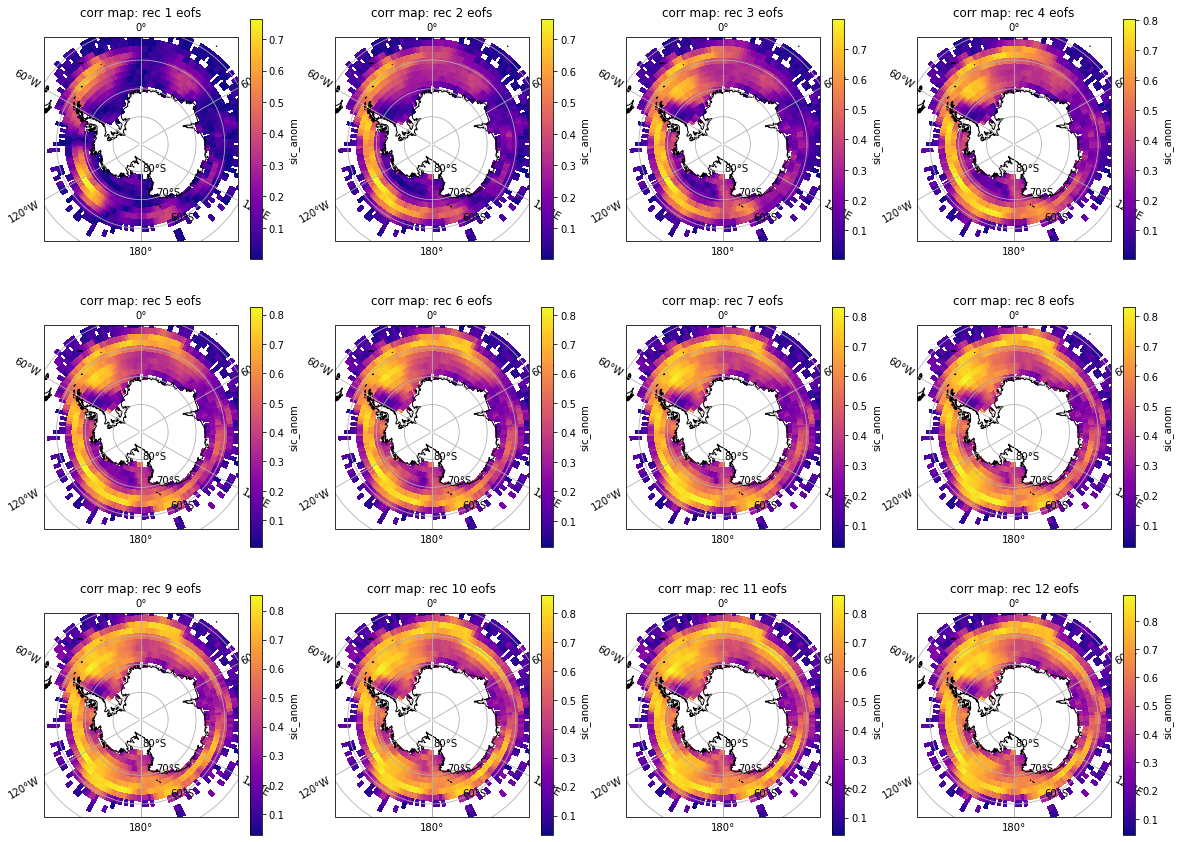

In [11]:
fig = plt.figure(figsize=(20,15))

neofs = 12
for neof in range(1, neofs + 1):
    reconstruction = xsolver.reconstructedField(neof)
    #reconstruction

    ax = plt.subplot(3, 4, neof, projection=sp)
    im = xr.corr(reconstruction, sic_anom, dim='tdim').plot(transform=pc, cmap="plasma")
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('corr map: rec ' + str(neof) + ' eofs')

# Using the new 1lonx0.5lat that took over an hour to build:

In [12]:
filename = '/d6/bxw2101/combined_netcdf_files/sic_anom_monthly_1x0p5.nc'
psic_anom_ds = xr.open_dataset(filename)
psic_anom = psic_anom_ds.sic_anom
psic_anom = psic_anom.fillna(0) # fillna(0) replaces all the nan values with zeroes. need to do this or else the solver doesn't work.
psic_anom_og = psic_anom.isel(tdim=slice(0, 264))

coslat = np.cos(np.deg2rad(psic_anom_ds.coords['y'].values)).clip(0., 1.)
wgts = coslat[..., np.newaxis]

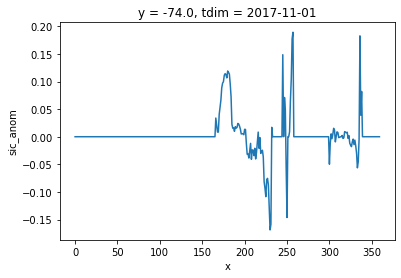

In [13]:
psic_anom.sel(tdim='2017-11-01').sel(y=-74).plot()
# OKAY! ALL OF THE INTEGER POINTS GOT ZEROES FOR THEIR ANOMALIES. DA FUCK???

[2.99892032 2.08341187 1.76935069 1.44216397 1.16049047]


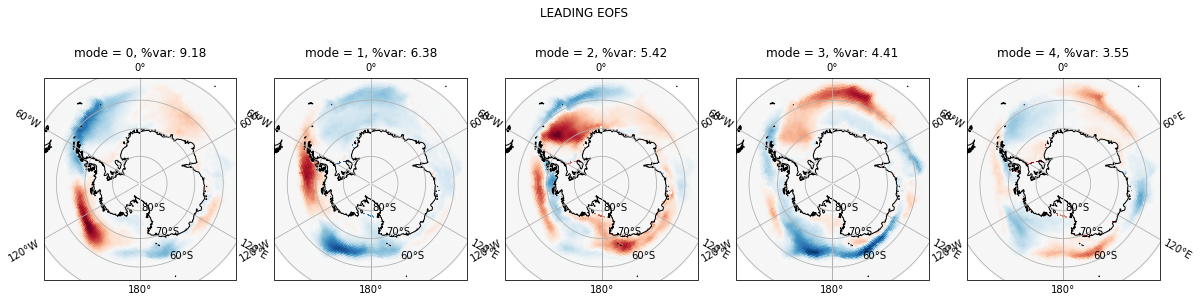

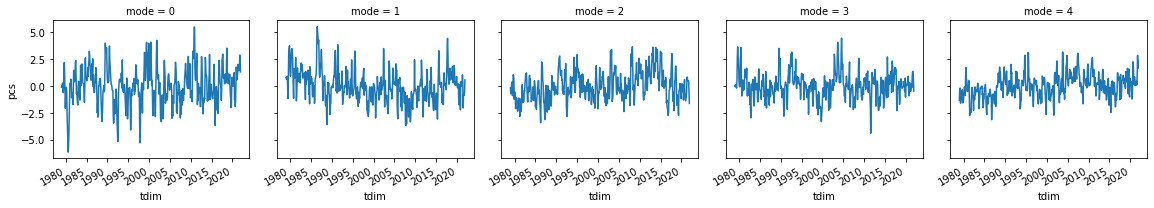

In [17]:
xsolver = Eof(psic_anom, weights=wgts)
modes = 5

eofs = xsolver.eofsAsCovariance(neofs=modes) # mode: 412, y: 20, x: 180
pcs = xsolver.pcs(npcs=modes) # tdim: 516, mode: 412
eigs = xsolver.eigenvalues(neigs=modes) 
sum_eigs = xsolver.eigenvalues().sum().data

# Plot EOFs
fig = plt.figure(figsize=(20,5))
for mode in range(modes):
    ax = plt.subplot(1, 5, mode + 1, projection=sp)
    im = eofs[mode].plot(transform=pc, add_colorbar=False)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
    ax.set_title('mode = ' + str(mode) + ', %var: ' + str(round(eigs[mode].data/sum_eigs * 100, 2)))
    
plt.suptitle('LEADING EOFS')
# eofs.plot(x='x',y='y',col='mode',col_wrap=modes,add_colorbar=0)

# Plot corresponding PCs
pcs.plot(x='tdim',col='mode',col_wrap=modes);
print(eigs.data)

# GOTTA REMOVE THE MONTHS GROUPBY BEFORE DOING ANY EOF SOLVING.

Text(0.5, 0.98, 'JUST SIC ANOMALY FOR ONE SINGLE POINT.')

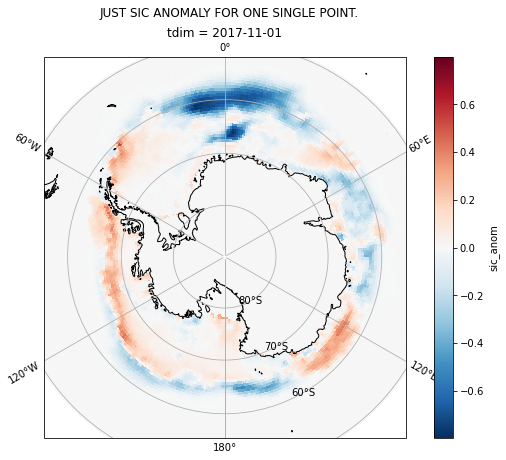

In [18]:
# this is just the sic anom for a single point. 2017-11-01 which u r very familiar with now.

arb_anom = psic_anom.sel(tdim='2017-11-01')

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_anom.plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
#arb_time.plot(transform=pc)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)
plt.suptitle('JUST SIC ANOMALY FOR ONE SINGLE POINT.')

# USING THE OG 25KMX25KM CELL SIZE GRID

In [19]:
filename = '/d6/bxw2101/seaice_conc_monthly/all_seaice_conc_monthly.nc'
sic_var = xr.open_dataset(filename).rename(time='tdim', xgrid='x', ygrid='y').cdr_seaice_conc_monthly.where(ds.cdr_seaice_conc_monthly < 2.51)
sic_mon = sic_var.groupby('tdim.month')
sic_clim = sic_mon.mean(dim='tdim')
ogsic_anom = sic_mon - sic_clim

NameError: name 'ds' is not defined

In [ ]:
ogsic_anom = ogsic_anom.drop_vars('month')

In [ ]:
ogsic_anom.sel(tdim='2017-11-01').plot()

In [ ]:
#OK THIS shit broke. woo
eofs = ogsolver.eofsAsCovariance(neofs=modes) # mode: 412, y: 20, x: 180
pcs = ogsolver.pcs(npcs=modes) # tdim: 518, mode: 412
eigs = ogsolver.eigenvalues(neigs=modes) 
sum_eigs = ogsolver.eigenvalues().sum().data

eofs.plot(x='x',y='y',col='mode',col_wrap=modes,add_colorbar=0)
pcs.plot(x='tdim',col='mode',col_wrap=modes);